# Exercise 1: Uniqueness

## The problem

In [the first tutorial](../tutorials/1_sphere_scatterer_null_field.ipynb), we looked at two formulations for a scattering problem with a Neumann boundary condition.

In this exercise, we will investigate the uniqueness so solutions to the boundary integral formulations for this problem.

## The formulation

In this exercise we will use the null field approach (as in [the first tutorial](../tutorials/1_sphere_scatterer_null_field.ipynb). This uses the following representation formula and boundary integral equation.

### Representation formula

$$
p_\text{total} = \mathcal{K}p_\text{total} + p_\text{inc}
$$

where $\mathcal{K}$ is the double layer potential operator.

### Boundary integral equation

$$
(\mathsf{K}-\tfrac{1}{2}\mathsf{Id})p_\text{total} = -p_\text{inc},
$$

where $\mathsf{K}$ is the double layer boundary operator, and $\mathsf{Id}$ is the identity operator.

## Finding a resonance

The code below plots the condition number of $\mathsf{K}-\tfrac{1}{2}\mathsf{Id}$ for 30 values of $k$ between 2.5 and 3.5. There is a sharp increase in the condition number near 3.2.

Adjust the limits use in `np.linspace` to approximate the value of $k$ for this spike to 4 or 5 decimal places. (For example, you might start be reducing the search to between 3.0 and 3.3, so `np.linspace(3.0, 3.3, 30)`.)

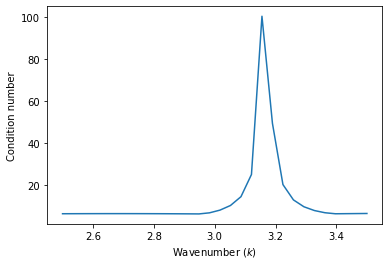

In [1]:
%matplotlib inline

import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

identity = sparse.identity(space, space, space)

x_data = []
y_data = []
for k in np.linspace(2.5, 3.5, 30):
    double_layer = helmholtz.double_layer(space, space, space, k)
    x_data.append(k)
    y_data.append(np.linalg.cond((double_layer - 0.5 * identity).weak_form().to_dense()))
    
plt.plot(x_data, y_data)
plt.xlabel("Wavenumber ($k$)")
plt.ylabel("Condition number")
plt.show()

## The effect on the solution

The code below has been copied from [the first tutorial](../tutorials/1_sphere_scatterer_null_field.ipynb) and the wavenumber has been changed to 3. The solution plot looks like a reasonable soluition.

Change the value of the wavenumber to the resonance that you found above. Does the solution still look reasonable?

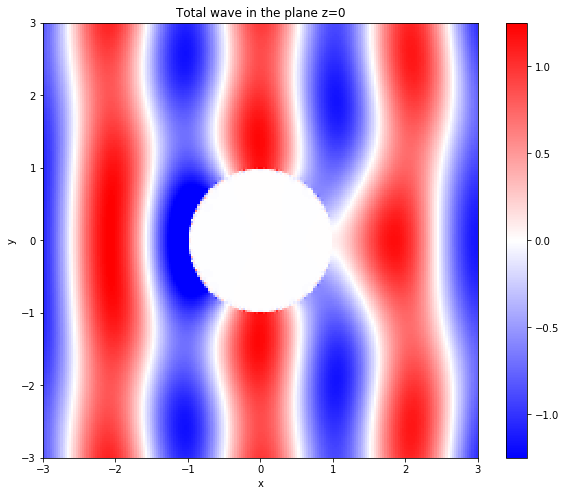

In [2]:
%matplotlib inline

import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 3.

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)

@bempp.api.complex_callable
def p_inc_callable(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

p_inc = bempp.api.GridFunction(space, fun=p_inc_callable)

p_total, info = gmres(double_layer - 0.5 * identity, -p_inc, tol=1E-5)

Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

p_inc_evaluated = np.real(np.exp(1j * k * points[0, :]))
p_inc_evaluated = p_inc_evaluated.reshape((Nx, Ny))
double_pot = helmholtz_potential.double_layer(space, points, k)
p_s = np.real(double_pot.evaluate(p_total))
p_s = p_s.reshape((Nx, Ny))

vmax = max((p_inc_evaluated + p_s).flat)

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real((p_inc_evaluated + p_s).T), extent=[-3, 3, -3, 3],
           cmap=plt.get_cmap("bwr"), vmin=-vmax, vmax=vmax)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()

## Obtaining the solution for this wavenumber: the Burton–Miller formulation

The Burton–Miller formulation can be used to obtain solutions to acoustic problems while avoiding spurious resonances.

### Representation formula

$$
p_\text{s} = \mathcal{K}p_\text{total},
$$

where $\mathcal{K}$ is the double layer potential operator.

### Boundary integral equation

$$
\left(\mathsf{K}-\tfrac{1}{2}\mathsf{Id}+\frac{1}{\mathsf{i}k}\mathsf{W}\right)p_\text{total}
=
-p_\text{inc} - \frac{1}{\mathsf{i}k}\frac{\partial p_\text{inc}}{\partial \mathbf{n}},
$$
where $\mathsf{K}$ is the double layer boundary operator; $\mathsf{W}$ is the hypersingular boundary operator; $\mathsf{K}$ is the double layer boundary operator; and $\mathsf{Id}$ is the identity operator.

### Solving with Bempp

Your task is to adapt and combine the example code in [the first tutorial](../examples/1_sphere_scatterer_null_field.ipynb) to solve the problem at the wavenumber you found above using the Burton–Miller formulation.

We can create the hypersingular operator in Bempp by calling `helmholtz.hypersingular`. Complex number can be used in Python by writing (for example) `2 + 1j`, `3j`, or `1j * 3`. In order for the hypersingular operator to be defined, we must use a P1 space. The code needed to create the relevant operators is given below. Your task is to use these to implement the Burton–Miller formulation.

Does the solution you obtain here look more reasonable that the solution above? You might like to adapt the previous example to use a P1 space to be sure that the resonances are still a problem with this alternative space.

In [3]:
%matplotlib inline

import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 1  # Enter your value here

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "P", 1)

identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)
hypersingular = helmholtz.hypersingular(space, space, space, k)





## What next?

After attempting this exercises, you should read [tutorial 2](../tutorials/2_sphere_scatterer_direct.ipynb).